In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate
!pip install torch
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [ ]:
from transformers import AlbertForQuestionAnswering, AutoTokenizer, DefaultDataCollator, AdamW, create_optimizer, Trainer, TrainingArguments, pipeline, DistilBertForQuestionAnswering, DistilBertTokenizer
from datasets import load_dataset
import numpy as np
from tqdm.auto import tqdm
import collections
import evaluate

import torch

In [ ]:
dataset = load_dataset("rajpurkar/squad_v2")

In [ ]:
dataset_10_percent = dataset["train"].train_test_split(test_size=0.9)["train"]

# Further split the 10% dataset into train and eval sets
dataset_split = dataset_10_percent.train_test_split(test_size=0.2)

In [ ]:
dataset_split

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10424
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 2607
    })
})

In [ ]:
test_dataset = dataset_split["test"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from transformers import AlbertTokenizer, AlbertForQuestionAnswering

# Define the model load path
model_load_path = "/content/drive/MyDrive/NLP Project/ALBERT/fine_tuned_albert"

tokenizer = AlbertTokenizer.from_pretrained(model_load_path)
model = AlbertForQuestionAnswering.from_pretrained(model_load_path)

context = "The Sistine Chapel is a chapel in the Apostolic Palace, the official residence of the pope, in Vatican City. The ceiling of the Sistine Chapel was painted by Michelangelo."
question = "Who painted the ceiling of the Sistine Chapel?"

inputs = tokenizer.encode_plus(question, context, return_tensors="pt", max_length=512, truncation=True)

with torch.no_grad():
    outputs = model(**inputs)

start_index = torch.argmax(outputs.start_logits)
end_index = torch.argmax(outputs.end_logits)
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][start_index:end_index+1]))

print("Question:", question)
print("Answer:", answer)

Question: Who painted the ceiling of the Sistine Chapel?
Answer: michelangelo


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using GPU: Tesla T4


In [ ]:
model.to(device)

AlbertForQuestionAnswering(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias

In [ ]:
qa_pipeline_albert = pipeline('question-answering', model=model, tokenizer=tokenizer)

In [ ]:
context="""In a recent survey conducted by the government,
public sector employees were asked to rate their level
of satisfaction with the department they work at.
The results revealed that NASA was the most popular
department with a satisfaction rating of 95%.

One NASA employee, John Smith, commented on the findings,
stating, "I'm not surprised that NASA came out on top.
It's a great place to work with amazing people and
incredible opportunities. I'm proud to be a part of
such an innovative organization.

The results were also welcomed by NASA's management team,
with Director Tom Johnson stating, "We are thrilled to
hear that our employees are satisfied with their work at NASA.
We have a talented and dedicated team who work tirelessly
to achieve our goals, and it's fantastic to see that their
hard work is paying off.

The survey also revealed that the
Social Security Administration had the lowest satisfaction
rating, with only 45% of employees indicating they were
satisfied with their job. The government has pledged to
address the concerns raised by employees in the survey and
work towards improving job satisfaction across all departments.
"""

In [ ]:
print("\n Question 1:")
answer=qa_pipeline_albert( question="Which department had the highest level of Satisfaction Rating?",
             context=context)
print(answer)


 Question 1:
{'score': 0.9606718420982361, 'start': 179, 'end': 183, 'answer': 'NASA'}


In [ ]:
context = \
"""
"The Veldt" is a science fiction short story by American author Ray Bradbury. \
Originally appearing as "The World the Children Made" in the September 23, 1950,\
issue of The Saturday Evening Post, it was republished under its current name in the 1951 anthology The Illustrated Man.

In the story, a mother and father struggle with their technologically advanced home taking over their role as parents, and their children becoming uncooperative as a result of their lack of discipline.
"""

In [ ]:
print("\n Question 1:")
answer=qa_pipeline_albert( question=""" Who is the author of "The Veldt"? """,
             context=context)
print(answer)

print("\n Question 2:")
answer=qa_pipeline_albert( question="""What is the original title of Ray Bradbury's short story "The Veldt"?""",
             context=context)
print(answer)


 Question 1:
{'score': 0.9567093849182129, 'start': 65, 'end': 78, 'answer': 'Ray Bradbury.'}

 Question 2:
{'score': 0.6633591055870056, 'start': 103, 'end': 132, 'answer': '"The World the Children Made"'}


In [ ]:
def get_predictions(dataset, qa_pipeline):
    predictions = []
    for example in tqdm(dataset, desc="Processing"):
        context = example['context']
        question = example['question']
        prediction = qa_pipeline({'context': context, 'question': question})
        predictions.append({
            'id': example['id'],
            'prediction_text': prediction['answer'],
            'no_answer_probability': prediction.get('no_answer_probability', 0.0)
        })
    return predictions


In [ ]:
predictions = get_predictions(dataset_split['test'], qa_pipeline_albert)

Processing:   0%|          | 0/2607 [00:00<?, ?it/s]

In [ ]:
def eval(predictions):
  metric = evaluate.load('squad_v2')

  references = [{'id': ex['id'], 'answers': ex['answers']} for ex in dataset_split['test']]

  final_score = metric.compute(predictions=predictions, references=references)

  return final_score

In [ ]:
albert_result = eval(predictions)

In [ ]:
for i in albert_result.keys():
  print(i + ": " + str(albert_result[i]))

exact: 42.96125815113157
f1: 52.67609047365324
total: 2607
HasAns_exact: 64.07322654462243
HasAns_f1: 78.5621097624794
HasAns_total: 1748
NoAns_exact: 0.0
NoAns_f1: 0.0
NoAns_total: 859
best_exact: 43.07633294975067
best_exact_thresh: 0.0
best_f1: 52.6760904736534
best_f1_thresh: 0.0


# **Loading DistilBert**

In [ ]:
model_load_path = "/content/drive/MyDrive/NLP Project/DistilBERT/fine_tuned_distilbert"

tokenizer = DistilBertTokenizer.from_pretrained(model_load_path)
model = DistilBertForQuestionAnswering.from_pretrained(model_load_path)


In [ ]:
qa_pipeline_distilbert = pipeline('question-answering', model=model, tokenizer=tokenizer)

In [ ]:
distilbert_predictions = get_predictions(dataset_split['test'], qa_pipeline_distilbert)

Processing:   0%|          | 0/2607 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
distilbert_result = eval(distilbert_predictions)

In [ ]:
for i in distilbert_result.keys():
  print(i + ": " + str(distilbert_result[i]))

exact: 30.418105101649406
f1: 40.037776384564275
total: 2607
HasAns_exact: 45.36613272311213
HasAns_f1: 59.713090980869026
HasAns_total: 1748
NoAns_exact: 0.0
NoAns_f1: 0.0
NoAns_total: 859
best_exact: 33.026467203682394
best_exact_thresh: 0.0
best_f1: 40.22640622478993
best_f1_thresh: 0.0


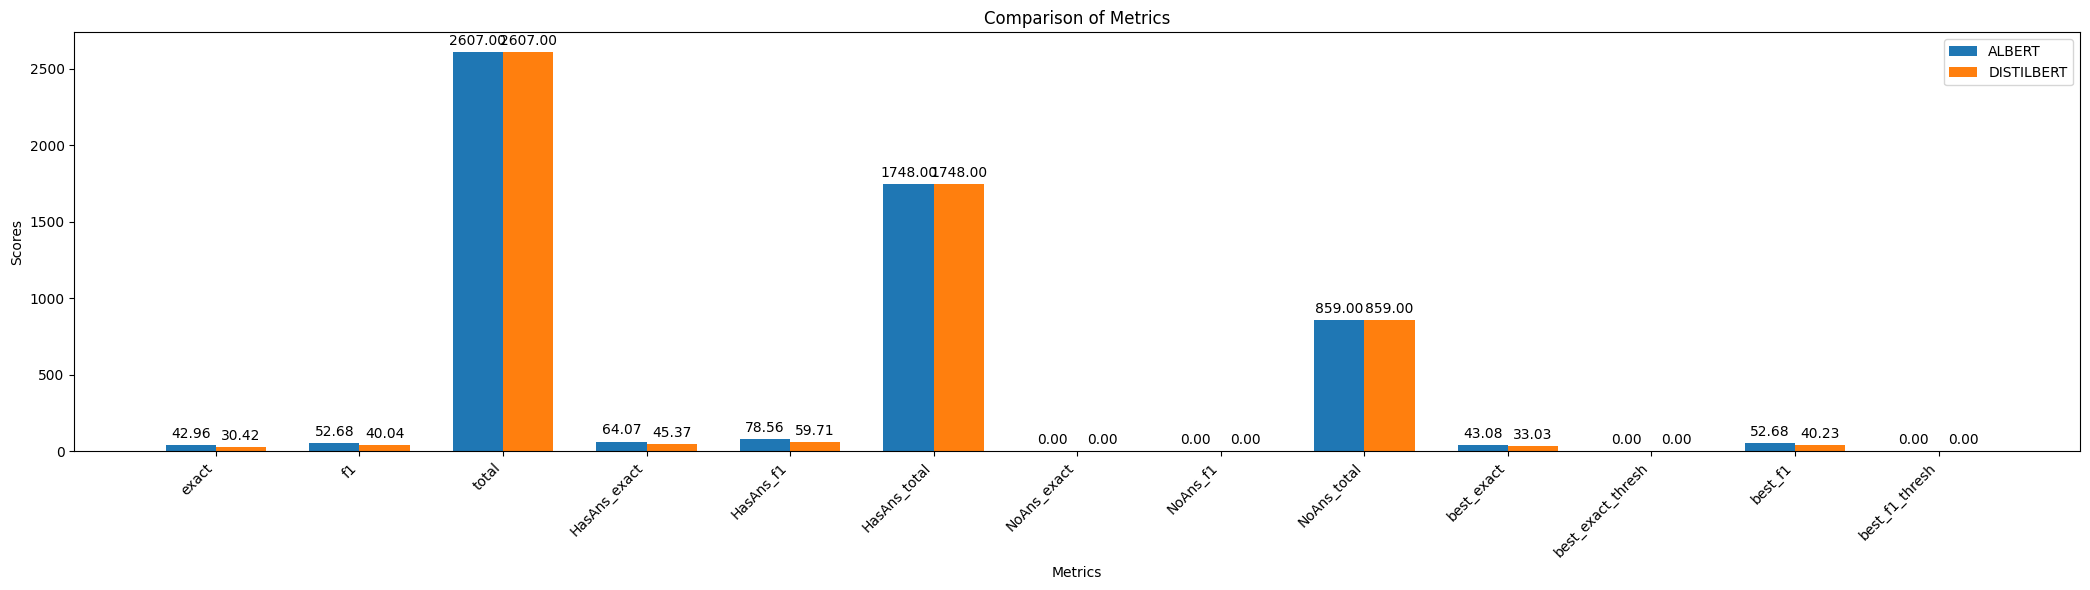

In [ ]:
import matplotlib.pyplot as plt
metric_names = list(albert_result.keys())
values1 = [albert_result[metric] for metric in metric_names]
values2 = [distilbert_result[metric] for metric in metric_names]

# Plotting
x = np.arange(len(metric_names))
width = 0.35

fig, ax = plt.subplots(figsize=(21, 6))
rects1 = ax.bar(x - width/2, values1, width, label='ALBERT')
rects2 = ax.bar(x + width/2, values2, width, label='DISTILBERT')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend()

# Function to add values above bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# **Test questions**

In [ ]:
def get_answer(context, question):
  albert_answer = qa_pipeline_albert(question=question,
                                   context=context)
  print("albert: ", albert_answer)
  print("albert answer: ", albert_answer['answer'])

  distilbert_answer = qa_pipeline_distilbert(question=question,
                                    context=context)
  print('\n', "distilbert: ", distilbert_answer)
  print("distilbert answer: ", distilbert_answer['answer'])

In [ ]:
# 1
question = "When did Beyonce start becoming popular?"
context = "Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles 'Crazy in Love' and 'Baby Boy'."

get_answer(context, question)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


albert:  {'score': 0.4593450129032135, 'start': 276, 'end': 286, 'answer': 'late 1990s'}
albert answer:  late 1990s

 distilbert:  {'score': 0.07945173978805542, 'start': 525, 'end': 532, 'answer': '(2003),'}
distilbert answer:  (2003),


In [ ]:
# 2
question = "Charlie's Angels featured which single from the band members?"
context = "The remaining band members recorded Independent Women Part I, which appeared on the soundtrack to the 2000 film, Charlie's Angels. It became their best-charting single, topping the U.S. Billboard Hot 100 chart for eleven consecutive weeks. In early 2001, while Destiny's Child was completing their third album, Beyoncé landed a major role in the MTV made-for-television film, Carmen: A Hip Hopera, starring alongside American actor Mekhi Phifer. Set in Philadelphia, the film is a modern interpretation of the 19th century opera Carmen by French composer Georges Bizet. When the third album Survivor was released in May 2001, Luckett and Roberson filed a lawsuit claiming that the songs were aimed at them. The album debuted at number one on the U.S. Billboard 200, with first-week sales of 663,000 copies sold. The album spawned other number-one hits, Bootylicious and the title track, Survivor, the latter of which earned the group a Grammy Award for Best R&B Performance by a Duo or Group with Vocals. After releasing their holiday album 8 Days of Christmas in October 2001, the group announced a hiatus to further pursue solo careers."

get_answer(context, question)

albert:  {'score': 0.6356240510940552, 'start': 48, 'end': 61, 'answer': 'Women Part I,'}
albert answer:  Women Part I,

 distilbert:  {'score': 0.02190241403877735, 'start': 36, 'end': 61, 'answer': 'Independent Women Part I,'}
distilbert answer:  Independent Women Part I,


In [ ]:
# 3
question = "how do we achieve a healthy body"
context = "an old man once said that the keys to everlasting wealth are health, friends, and family. A healthy body will give you strength, to achieve this one must eat healthily and excercise daily"

get_answer(context, question)

albert:  {'score': 0.13834074139595032, 'start': 154, 'end': 181, 'answer': 'eat healthily and excercise'}
albert answer:  eat healthily and excercise

 distilbert:  {'score': 0.1579628735780716, 'start': 119, 'end': 128, 'answer': 'strength,'}
distilbert answer:  strength,


In [ ]:
#Terjadi Kesalahan dalam menjawab pertanyaan jika di dalam context, jawaban dipisah menjadi beberapa bagian

question = "what can we do to get a healthy body"
context = "an old man once said that the keys to everlasting wealth are health, friends, and family. A healthy body will give you strength, to achieve this one must eat healthily and excercise daily. other than that to get a healthy body one can also relax the body with meditation."

get_answer(context, question)

albert:  {'score': 0.37914660573005676, 'start': 240, 'end': 270, 'answer': 'relax the body with meditation.'}
albert answer:  relax the body with meditation.

 distilbert:  {'score': 0.2230222523212433, 'start': 240, 'end': 270, 'answer': 'relax the body with meditation.'}
distilbert answer:  relax the body with meditation.


In [ ]:
#mampu menjawab pertanyaan mengenai subjek dengan pertanyaan spesifik
question = "who said that the keys to everlasting wealth are health, friends, and family"
context = "an old man named george luther spencer the fiftienth once said that the keys to everlasting wealth are health, friends, and family. A healthy body will give you strength, to achieve this one must eat healthily and excercise daily. other than that to get a healthy body one can also relax the body with meditation."

get_answer(context, question)

albert:  {'score': 0.5032110810279846, 'start': 17, 'end': 52, 'answer': 'george luther spencer the fiftienth'}
albert answer:  george luther spencer the fiftienth

 distilbert:  {'score': 0.1936442255973816, 'start': 17, 'end': 38, 'answer': 'george luther spencer'}
distilbert answer:  george luther spencer


In [ ]:
#mampu menjawab pertanyaan mengenai subjek dengan pertanyaan non spesifik
question = "who said that"
context = "an old man named george luther spencer the fiftienth once said that the keys to everlasting wealth are health, friends, and family. A healthy body will give you strength, to achieve this one must eat healthily and excercise daily. other than that to get a healthy body one can also relax the body with meditation."

get_answer(context, question)

albert:  {'score': 0.14304068684577942, 'start': 3, 'end': 52, 'answer': 'old man named george luther spencer the fiftienth'}
albert answer:  old man named george luther spencer the fiftienth

 distilbert:  {'score': 0.03103053942322731, 'start': 17, 'end': 38, 'answer': 'george luther spencer'}
distilbert answer:  george luther spencer


In [ ]:
#tidak mampu menjawab pertanyaan mengenai subjek dengan pertanyaan yes or no
question = "is george an old man?"
context = "an old man named george luther spencer the fiftienth once said that the keys to everlasting wealth are health, friends, and family. A healthy body will give you strength, to achieve this one must eat healthily and excercise daily. other than that to get a healthy body one can also relax the body with meditation."

get_answer(context, question)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


albert:  {'score': 0.10794579237699509, 'start': 3, 'end': 10, 'answer': 'old man'}
albert answer:  old man

 distilbert:  {'score': 0.052666157484054565, 'start': 17, 'end': 38, 'answer': 'george luther spencer'}
distilbert answer:  george luther spencer


In [ ]:
question = "how old is max"
context = "Max verstappen, a 20 year old formula 1 champion, is highly praised by many fans in his home country 'belgium'"

get_answer(context, question)

albert:  {'score': 0.43299585580825806, 'start': 18, 'end': 20, 'answer': '20'}
albert answer:  20

 distilbert:  {'score': 0.017996225506067276, 'start': 101, 'end': 109, 'answer': "'belgium'"}
distilbert answer:  'belgium'


In [ ]:
question = "where is max's home country"
context = "Max verstappen, a 20 year old formula 1 champion, is highly praised by many fans in his home country 'belgium'"

get_answer(context, question)

albert:  {'score': 0.3458032011985779, 'start': 101, 'end': 109, 'answer': "'belgium'"}
albert answer:  'belgium'

 distilbert:  {'score': 0.3605988323688507, 'start': 101, 'end': 109, 'answer': "'belgium'"}
distilbert answer:  'belgium'


In [ ]:
question = "who is max's rival"
context = "Max verstappen, a 20 year old formula 1 champion, is highly praised by many fans in his home country 'belgium'. He is praised because of his amazing performances during the formula 1 championship in 2023 where he manages to beat his rival lewis hamilton."

get_answer(context, question)

albert:  {'score': 0.8676533102989197, 'start': 239, 'end': 253, 'answer': 'lewis hamilton.'}
albert answer:  lewis hamilton.

 distilbert:  {'score': 0.7206647992134094, 'start': 239, 'end': 253, 'answer': 'lewis hamilton.'}
distilbert answer:  lewis hamilton.


In [ ]:
question = "why is max praised"
context = "Max verstappen, a 20 year old formula 1 champion, is highly praised by many fans in his home country 'belgium'. test gap .He is praised because of his amazing performances during the formula 1 championship in 2023 where he manages to beat his rival lewis hamilton."

get_answer(context, question)

albert:  {'score': 0.2931775450706482, 'start': 147, 'end': 213, 'answer': 'his amazing performances during the formula 1 championship in 2023'}
albert answer:  his amazing performances during the formula 1 championship in 2023

 distilbert:  {'score': 0.06674473732709885, 'start': 101, 'end': 111, 'answer': "'belgium'."}
distilbert answer:  'belgium'.


In [ ]:
context = \
"""
Walter Elias Disney (/ˈdɪzni/;[2] December 5, 1901 – December 15, 1966) was an American animator, film producer, voice actor, and entrepreneur. A pioneer of the American animation industry, he introduced several developments in the production of cartoons. As a film producer, he holds the record for most Academy Awards earned and nominations by an individual. He was presented with two Golden Globe Special Achievement Awards and an Emmy Award, among other honors. Several of his films are included in the National Film Registry by the Library of Congress and have also been named as some of the greatest films ever by the American Film Institute.

Born in Chicago in 1901, Disney developed an early interest in drawing. He took art classes as a boy and took a job as a commercial illustrator at the age of 18. He moved to California in the early 1920s and set up the Disney Brothers Studio (now The Walt Disney Company) with his brother Roy. With Ub Iwerks, he developed the character Mickey Mouse in 1928, his first highly popular success; he also provided the voice for his creation in the early years. As the studio grew, he became more adventurous, introducing synchronized sound, full-color three-strip Technicolor, feature-length cartoons and technical developments in cameras. The results, seen in features such as Snow White and the Seven Dwarfs (1937), Pinocchio, Fantasia (both 1940), Dumbo (1941), and Bambi (1942), furthered the development of animated film. New animated and live-action films followed after World War II, including the critically successful Cinderella (1950), Sleeping Beauty (1959) and Mary Poppins (1964), the last of which received five Academy Awards.

In the 1950s, Disney expanded into the theme park industry, and in July 1955 he opened Disneyland in Anaheim, California. To fund the project he diversified into television programs, such as Walt Disney's Disneyland and The Mickey Mouse Club. He was also involved in planning the 1959 Moscow Fair, the 1960 Winter Olympics, and the 1964 New York World's Fair. In 1965, he began development of another theme park, Disney World, the heart of which was to be a new type of city, the "Experimental Prototype Community of Tomorrow" (EPCOT). Disney was a heavy smoker throughout his life and died of lung cancer in 1966 before either the park or the EPCOT project were completed.

Disney was a shy, self-deprecating and insecure man in private but adopted a warm and outgoing public persona. He had high standards and high expectations of those with whom he worked. Although there have been accusations that he was racist or antisemitic, they have been contradicted by many who knew him. Historiography of Disney has taken a variety of perspectives, ranging from views of him as a purveyor of homely patriotic values to being a representative of American cultural imperialism. Widely considered to be one of the most influential cultural figures of the 20th century, Disney remains an important presence in the history of animation and in the cultural history of the United States, where he is acknowledged as a national cultural icon. His film work continues to be shown and adapted, the Disney theme parks have grown in size and number around the world and his company has grown to become one of the world's largest mass media and entertainment conglomerates.
"""

question = \
"""
what film does disney make?
"""

get_answer(context, question)


albert:  {'score': 0.7350196242332458, 'start': 247, 'end': 256, 'answer': 'cartoons.'}
albert answer:  cartoons.

 distilbert:  {'score': 0.014880562201142311, 'start': 1459, 'end': 1467, 'answer': 'animated'}
distilbert answer:  animated


In [ ]:
# 2 pertanyaan tapi cuma bisa jawab salah 1
question = \
"""
Why was Walt Disney considered a pioneer of the American animation industry, and when did disneyland in anaheim opened?
"""

get_answer(context, question)

albert:  {'score': 0.975292444229126, 'start': 1762, 'end': 1766, 'answer': '1955'}
albert answer:  1955

 distilbert:  {'score': 0.4201178550720215, 'start': 1757, 'end': 1766, 'answer': 'July 1955'}
distilbert answer:  July 1955


In [ ]:
question = \
"""
what are the results after the studio grew?
"""

get_answer(context, question)

albert:  {'score': 0.21729861199855804, 'start': 1224, 'end': 1286, 'answer': 'feature-length cartoons and technical developments in cameras.'}
albert answer:  feature-length cartoons and technical developments in cameras.

 distilbert:  {'score': 0.0906798243522644, 'start': 1325, 'end': 1356, 'answer': 'Snow White and the Seven Dwarfs'}
distilbert answer:  Snow White and the Seven Dwarfs


In [ ]:
question = \
"""
what film that received 5 awards?
"""

get_answer(context, question)

albert:  {'score': 0.5387112498283386, 'start': 1620, 'end': 1632, 'answer': 'Mary Poppins'}
albert answer:  Mary Poppins

 distilbert:  {'score': 0.0203576497733593, 'start': 1914, 'end': 1932, 'answer': 'Mickey Mouse Club.'}
distilbert answer:  Mickey Mouse Club.


In [ ]:
context = \
"""
Over the past century, the dynamics of global trade have undergone significant transformations due to technological advancements, policy shifts, and geopolitical changes. The establishment of international trade organizations, such as the World Trade Organization (WTO), has played a crucial role in facilitating and regulating global trade. These organizations aim to promote free trade by reducing tariffs, eliminating trade barriers, and resolving disputes between member countries. The advent of containerization and advancements in logistics have drastically reduced shipping costs and increased the efficiency of global supply chains. Digital technologies, including the internet and blockchain, have further revolutionized trade by enabling real-time tracking, enhancing transparency, and reducing transaction times.

However, the benefits of global trade have not been evenly distributed, leading to significant economic disparities between developed and developing nations. While developed countries have reaped substantial economic gains, many developing countries have struggled to compete in the global market due to a lack of infrastructure, technological capabilities, and access to capital. Moreover, globalization has led to concerns about labor exploitation, environmental degradation, and the erosion of local cultures and industries.

In recent years, there has been a growing movement towards protectionism, with some countries imposing tariffs and trade restrictions to protect domestic industries and jobs. This shift has been fueled by rising nationalism, economic inequality, and disillusionment with the promises of globalization. The trade war between the United States and China is a prominent example of this trend, with both countries imposing tariffs on billions of dollars' worth of goods. This conflict has not only affected the economies of the involved nations but has also disrupted global supply chains, impacting businesses and consumers worldwide.

Furthermore, the COVID-19 pandemic has exposed vulnerabilities in global supply chains, leading to shortages of essential goods and prompting countries to reconsider their reliance on foreign suppliers. This has sparked debates about the need for greater economic self-sufficiency and the potential risks of over-dependence on global trade. As countries grapple with these challenges, there is an ongoing debate about the future of global trade and the best path forward to ensure equitable and sustainable economic growth.
"""

question = \
"""
Why is it essential to balance the benefits of global trade with the need for protectionism and economic self-sufficiency, particularly in the context of current geopolitical tensions and supply chain vulnerabilities?
"""

get_answer(context, question)

albert:  {'score': 0.11408460140228271, 'start': 769, 'end': 825, 'answer': 'enhancing transparency, and reducing transaction times.'}
albert answer:  enhancing transparency, and reducing transaction times.

 distilbert:  {'score': 0.01634296216070652, 'start': 2296, 'end': 2328, 'answer': 'over-dependence on global trade.'}
distilbert answer:  over-dependence on global trade.
